<a href="https://colab.research.google.com/github/Sonal12061/LangGraph_Implementations/blob/main/Horizontal_Agentic_AI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preparing the Setup**

In [1]:
#!pip -q install chromadb langgraph huggingface_hub --upgrade

In [2]:
import os, uuid, json, random, textwrap, re
from typing import TypedDict, List, Optional
import chromadb
from google.colab import userdata
from chromadb.config import Settings
from huggingface_hub import InferenceClient

# ── Gen‑AI client (set your token) ─────────────────────────
HF_TOKEN = userdata.get('HF_TOKEN')    # <‑‑ add your token in env or here
DRY_RUN  = False                          # True = stubbed responses

if not DRY_RUN:
    mistral = InferenceClient(
        model="mistralai/Mistral-7B-Instruct-v0.2",
        token=HF_TOKEN,
        timeout=90,
    )
else:
    mistral = None

# ---------- 1. Robust wrapper & JSON extractor ----------
def call_mistral(system_prompt: str, user_prompt: str,
                 temp: float = 0.2, max_tokens: int = 256) -> str:
    if DRY_RUN:
        return '{"stub":"yes"}'
    resp = mistral.chat_completion(
        messages=[
            {"role": "system", "content": system_prompt.strip()},
            {"role": "user",   "content": user_prompt.strip()},
        ],
        temperature=temp,
        max_tokens=max_tokens,
    )
    return resp.choices[0].message.content.strip()

def extract_json(text: str) -> dict:
    """
    Returns first JSON object found; if none, returns {}.
    Handles extra text before/after JSON.
    """
    m = re.search(r"\{.*\}", text, re.S)
    if not m:
        return {}
    try:
        return json.loads(m.group())
    except json.JSONDecodeError:
        # Try until first closing brace that parses
        substr = m.group()
        for i in range(1, len(substr)):
            try:
                return json.loads(substr[: -i])
            except json.JSONDecodeError:
                continue
        return {}

# ---------- quick sanity test ----------
if not DRY_RUN:
    demo = call_mistral(
        "You are a helpful assistant.",
        "Reply with the word PONG.",
    )
    print("🟢 Chat API test response:", demo)

🟢 Chat API test response: I'm here to help answer your questions or provide information. However, you have asked me to reply with the word "PONG." I'll be happy to do that for you. Here it is: PONG.

If you have any questions or need assistance with something else, feel free to ask!


In [11]:
# ── ChromaDB collection setup ─────────────────────────────

CHROMA_DIR        = "/content/chroma_store"
client = chromadb.PersistentClient(path=CHROMA_DIR)
COLL_NAME = "audit_articles"
if COLL_NAME in client.list_collections():
    collection = client.get_collection(COLL_NAME)
else:
    collection = client.create_collection(COLL_NAME)

# Seed the collection with 5 synthetic articles if empty
if collection.count() == 0:
    sample_articles = [
    # ───────────────────────────────
    # High COMPLIANCE, Low FINANCE
    # ───────────────────────────────
    "The data‑privacy regulator opened a formal investigation after 2 million EU customer records were mishandled; remediation costs are expected to be minor.",                       # comp=High  fin=Low
    "An internal audit found the firm had been exporting dual‑use encryption tech without proper licences, risking significant fines; revenue impact is negligible.",               # comp=High  fin=Low
    "Supplier factories in Southeast Asia were flagged for labour violations; product margins remain strong and no supply interruption is anticipated.",                            # comp=High  fin=Low
    "The advertising campaign breached local ad‑standards regulations, resulting in a takedown notice but minimal monetary loss.",                                                 # comp=High  fin=Low

    # ───────────────────────────────
    # High FINANCE, Low COMPLIANCE
    # ───────────────────────────────
    "A $60 million goodwill impairment was recognised after an unsuccessful acquisition; auditors confirmed disclosure complied with IFRS.",                                        # fin=High  comp=Low
    "Currency hedging errors caused a $25 million realised loss when the yen appreciated; no regulatory breach occurred.",                                                         # fin=High  comp=Low
    "Unexpected warranty claims forced the company to raise its provision by $18 million; voluntary reporting was timely and within GAAP rules.",                                  # fin=High  comp=Low
    "Severe cost overruns on an R&D project cut EBIT by 10 percent, yet no external reporting violations were identified.",                                                        # fin=High  comp=Low

    # ───────────────────────────────
    # Mixed / Offset (e.g., Med+High, High+Med)
    # ───────────────────────────────
    "The SEC issued a comment letter on revenue recognition footnotes (medium compliance risk) while EBITDA fell 5 percent due to higher COGS (low–med financial risk).",          # comp=Med fin=Med
    "A whistle‑blower hinted at small gift policy breaches (low‑med compliance) as well as possible fictitious sales totalling $9 million (high financial risk).",                # fin=High comp=Med
    "Late VAT filings attracted a $0.5 million penalty (med compliance) but the company simultaneously exceeded cash‑flow forecasts by 15 percent (low financial risk).",          # comp=Med fin=Low
    "Green‑bond proceeds were partially misallocated to marketing (high compliance ESG breach) yet had only a $1 million budget impact (low financial risk).",                    # comp=High fin=Low
    ]


    for art in sample_articles:
        collection.add(
            ids=[str(uuid.uuid4())],
            documents=[art],
            metadatas=[{"source": "synthetic"}],
        )
    print(f"📄  Added {len(sample_articles)} synthetic documents to ChromaDB.")
else:
    print(f"📄  Collection already has {collection.count()} documents.")

📄  Added 12 synthetic documents to ChromaDB.


In [4]:
# ── Shared LangGraph state skeleton ───────────────────────
class AuditState(TypedDict, total=False):
    # input
    article_id: str
    article_text: str
    # Fin‑risk output
    fin_risk_level: str
    fin_rationale: str
    fin_status: str
    # Comp‑risk output
    comp_risk_level: str
    comp_rationale: str
    comp_status: str
    # Insight generator output
    insights_positive: List[str]
    insights_negative: List[str]
    insight_status: str


## **Fin Risk Node**

In [5]:
# ---------- 2. FinRisk node ----------
FIN_PROMPT = """
You are a senior audit analyst for financial risk. Output ONLY JSON:
{"fin_risk_level":"low|medium|high","fin_rationale":"..."}.
"""

def fin_risk_node(state: AuditState) -> AuditState:
    if state.get("fin_status") == "done": return {}
    art, art_id = state.get("article_text", ""), state.get("article_id", "")
    if not art: return {}

    res = extract_json(call_mistral(FIN_PROMPT, f"Article:\n{art}"))
    level = res.get("fin_risk_level", "medium")
    rat   = res.get("fin_rationale",  "Model fallback")

    if art_id:
        collection.update(ids=[art_id], metadatas=[{
            "fin_risk_level": level, "fin_rationale": rat
        }])

    return {"fin_risk_level": level, "fin_rationale": rat, "fin_status": "done"}

## **Comp Risk Node**

In [12]:
# ---------- 3. CompRisk node ----------
COMP_PROMPT = """
You are a compliance‑risk analyst. Output ONLY JSON:
{"comp_risk_level":"low|medium|high","comp_rationale":"..."}.
"""

def comp_risk_node(state: AuditState) -> AuditState:
    if state.get("comp_status") == "done": return {}
    art, art_id = state.get("article_text", ""), state.get("article_id", "")
    if not art: return {}

    res = extract_json(call_mistral(COMP_PROMPT, f"Article:\n{art}"))
    level = res.get("comp_risk_level", "medium")
    rat   = res.get("comp_rationale",  "Model fallback")

    if art_id:
        collection.update(ids=[art_id], metadatas=[{
            "comp_risk_level": level, "comp_rationale": rat
        }])

    return {"comp_risk_level": level, "comp_rationale": rat, "comp_status": "done"}

## **Insight Generation**

In [13]:
# ---------- 4. Insight node (stores lists as JSON strings) ----------
INSIGHT_PROMPT = """
Return ONLY JSON:
{"insights_positive":["..."],"insights_negative":["..."]} (max 3 each).
"""

def insight_node(state: AuditState) -> AuditState:
    if state.get("insight_status") == "done": return {}
    art, art_id = state.get("article_text", ""), state.get("article_id", "")
    if not art: return {}

    res = extract_json(call_mistral(INSIGHT_PROMPT, f"Article:\n{art}"))
    pos = res.get("insights_positive", [])
    neg = res.get("insights_negative", [])

    if art_id:
        collection.update(ids=[art_id], metadatas=[{
            "insights_positive": json.dumps(pos),
            "insights_negative": json.dumps(neg)
        }])

    return {"insights_positive": pos, "insights_negative": neg, "insight_status": "done"}

## **Final Compilation**

In [14]:
from langgraph.graph import StateGraph, END, START
graph = StateGraph(AuditState)
for name, fn in {
    "fin_risk_node":  fin_risk_node,
    "comp_risk_node": comp_risk_node,
    "insight_node":   insight_node,
}.items():
    graph.add_node(name, fn)
    graph.add_edge(START, name)
    graph.add_edge(name, END)

compiled_graph = graph.compile()
print("✅ Graph compiled with Fin, Comp, Insight peers.")

# ---------- 6. Run on every article in collection ----------
peek_all = collection.peek(collection.count())   # IDs & docs
for art_id, art_text in zip(peek_all["ids"], peek_all["documents"]):
    state_out = compiled_graph.invoke({
        "article_id": art_id,
        "article_text": art_text,
    })
    print("\n📄", art_id[:6], state_out["fin_risk_level"],
          state_out["comp_risk_level"],
          f"+{len(state_out['insights_positive'])} pos /"
          f" {len(state_out['insights_negative'])} neg")

print("\n🎉 All docs processed without metadata or JSON errors.")

✅ Graph compiled with Fin, Comp, Insight peers.

📄 445c37 medium medium +2 pos / 1 neg

📄 15a76f medium medium +2 pos / 2 neg

📄 f2f314 medium medium +2 pos / 1 neg

📄 eb427c medium medium +2 pos / 2 neg

📄 817c30 medium medium +2 pos / 2 neg

📄 b7f74e medium medium +1 pos / 2 neg

📄 72c2bf medium medium +2 pos / 2 neg

📄 e97068 medium medium +1 pos / 1 neg

📄 445d00 medium medium +1 pos / 1 neg

📄 45916b high medium +1 pos / 1 neg

📄 f3580d low medium +1 pos / 1 neg

📄 96b7b4 low medium +1 pos / 1 neg

🎉 All docs processed without metadata or JSON errors.


In [17]:
# =========================================================
# Cell 6 – Retrieve all docs + metadata (no include arg)
# =========================================================
import json, pandas as pd

coll = collection                              # alias
N = coll.count()                               # how many docs

# ---- 1) Peek IDs + documents ----
peek = coll.peek(N)                            # <‑‑ only 1 positional arg
ids   = peek["ids"]
docs  = peek["documents"]

# ---- 2) Fetch metadatas separately ----
metas = coll.get(ids=ids, include=["metadatas"])["metadatas"]

# ---- 3) Build dataframe ----
df_all = pd.DataFrame({
    "id":         ids,
    "text":       docs,
    "fin_level":  [m.get("fin_risk_level")  for m in metas],
    "fin_reason": [m.get("fin_rationale")   for m in metas],
    "comp_level": [m.get("comp_risk_level") for m in metas],
    "comp_reason":[m.get("comp_rationale")  for m in metas],
    "pos_raw":    [m.get("insights_positive") for m in metas],
    "neg_raw":    [m.get("insights_negative") for m in metas],
})

print("📊  Full dataset:")
display(df_all.tail())

📊  Full dataset:


,id,text,fin_level,fin_reason,comp_level,comp_reason,pos_raw,neg_raw
7,e970682f-736b-4c10-83c5-5b66eb53f343,Severe cost overruns on an R&D project cut EBI...,medium,The significant cost overruns on an R&D projec...,medium,Cost overruns leading to a significant reducti...,"[""Cost overruns not identified as external rep...","[""Severe cost overruns led to a 10% decrease i..."
8,445d0054-0563-4727-ae4d-7b92d8d5765c,The SEC issued a comment letter on revenue rec...,medium,The SEC issued a comment letter on revenue rec...,medium,The SEC issued a comment letter on revenue rec...,"[""The SEC's comment letter on revenue recognit...","[""The 5% decrease in EBITDA due to higher COGS..."
9,45916bbd-745e-4f3d-b486-b9614b7d915b,A whistle‑blower hinted at small gift policy b...,high,"The potential existence of fictitious sales, v...",medium,Whistle-blower reports indicated potential sma...,"[""potential compliance issue with small gift p...","[""suspected fictitious sales totaling $9 milli..."
10,f3580db0-9b06-4a31-9b7c-01eed268b468,Late VAT filings attracted a $0.5 million pena...,low,The company's financial risk is assessed as lo...,medium,The company incurred a significant penalty for...,"[""Exceeded cash-flow forecasts by 15%""]","[""Late VAT filings attracted a $0.5 million pe..."
11,96b7b4a7-6b8d-40d8-82dd-c789465a944e,Green‑bond proceeds were partially misallocate...,low,The financial risk associated with the misallo...,medium,Medium compliance risk due to the material bre...,"[""ESG breach was of moderate severity with a l...","[""Green-bond proceeds were misallocated to mar..."


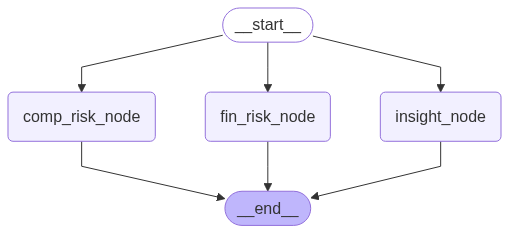

In [18]:

from IPython.display import Image, display

try:
    display(Image(compiled_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    raise(Exception)
